In [1]:
# conda create -n rnnTutorial python=3.7 pip matplotlib jupyterlab nb_conda
# conda activate rnnTutorial
# pip install torch
# jupyter lab


# !pip install torch, scikit-learn, seaborn

%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from RNNCell_base import * 
                        
class RNNCell(RNNCell_base): 
#     __constants__ = ['decay']

    def __init__(self, input_size, hidden_size, nonlinearity = None, bias = True, decay = 0.9):
        super().__init__(input_size, hidden_size, nonlinearity, bias)
        self.decay = decay    #  torch.exp( - dt/tau )

#     @jit.script_method
    def forward(self, input, hidden):                        
        # type: (Tensor, Tensor) -> Tensor
        activity = self.nonlinearity(input @ self.weight_ih.t() +  hidden @ self.weight_hh.t() + self.bias)
        hidden   = self.decay * hidden + (1 - self.decay) * activity
#         hidden   = activity   # for discrete-time model (decay = 0)
        return hidden 

class RNNLayer(nn.Module):  #   (jit.ScriptModule): 
    def __init__(self, RNNcell, *args):
        super().__init__()
        self.RNNcell = RNNcell(*args)

#     @jit.script_method
    def forward(self, input, state):
        # type: (Tensor, Tensor) -> Tuple[Tensor, Tensor]
        inputs = input.unbind(0)
        state = state[0]
        outputs = []
        for i in range(len(inputs)):
            state = self.RNNcell(inputs[i], state)
            outputs += [state]
        return torch.stack(outputs), state

In [3]:
T, batch = 3000, 100
n_input, n_rnn, n_output = 10, 500, 5

x       = torch.randn(T, batch, n_input)
hidden0 = torch.zeros([1, batch, n_rnn])

rnn  = RNNLayer(RNNCell, n_input, n_rnn, nn.ReLU(), 0.9, True)
# rnn  = nn.RNN(n_input, n_rnn, nonlinearity = 'relu')
# rnn  = nn.LSTM(n_input, n_rnn, nonlinearity = 'relu')

output, hidden = rnn(x, hidden0)

In [4]:

class Model(nn.Module):         # (jit.ScriptModule):  #
#     __constants__ = ['n_rnn']
    def __init__(self, hp):    
        super().__init__()
        n_input, n_rnn, n_output, decay = hp['n_input'], hp['n_rnn'], hp['n_output'], hp['decay']
        
        if hp['activation'] == 'relu':    # Type of activation runctions, relu, softplus, tanh, elu
            nonlinearity = nn.ReLU()
        else: 
            raise NotImplementedError
        
#         self.hp    = hp
        self.n_rnn = n_rnn
        self.rnn   = RNNLayer(RNNCell, n_input, n_rnn, nonlinearity, decay)
        self.readout = nn.Linear(n_rnn, n_output, bias = False)
        
#     @jit.script_method
    def forward(self, x):
        # type: (Tensor) -> Tuple[Tensor, Tensor]
        hidden0   = torch.zeros([1, x.shape[1], self.n_rnn])
        hidden, _ = self.rnn(x, hidden0)
        output    = self.readout(hidden)
        return output, hidden
        

In [6]:
from train_pytorch import set_hyperparameters, train, Run_Model
hp, log, optimizer  = set_hyperparameters(model_dir='debug', hp={'learning_rate': 0.001}, ruleset='mante')
# rnn_model = RNN_Model(hp, nn.ReLU(), 0.9)
model = Model(hp)
run_model = Run_Model(hp, model)
train(run_model, optimizer, hp, log)

Trial       0  | Time 0.00 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.571196| c_reg 0.000000  | perf 0.22
contextdm2     | cost 0.682435| c_reg 0.000000  | perf 0.23
Trial   32000  | Time 63.20 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.208474| c_reg 0.000000  | perf 0.47
contextdm2     | cost 0.205566| c_reg 0.000000  | perf 0.49
Optimization interrupted by user
Optimization finished!


Trial       0  | Time 0.00 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.599391| c_reg 0.000000  | perf 0.16
contextdm2     | cost 0.725027| c_reg 0.000000  | perf 0.18
Trial   32000  | Time 63.05 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.211081| c_reg 0.000000  | perf 0.49
contextdm2     | cost 0.210209| c_reg 0.000000  | perf 0.48
Trial   64000  | Time 125.69 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.167836| c_reg 0.000000  | perf 0.63
contextdm2     | cost 0.169717| c_reg 0.000000  | perf 0.62
Trial   96000  | Time 188.96 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.139632| c_reg 0.000000  | perf 0.74
contextdm2     | cost 0.159149| c_reg 0.000000  | perf 0.66
Trial  128000  | Time 253.53 s  | Now training contextdm1 & contextdm2
contextdm1     | cost 0.106592| c_reg 0.000000  | perf 0.79
contextdm2     | cost 0.124210| c_reg 0.000000  | perf 0.77
Trial  160000  | Time 317.61 s  | Now training c

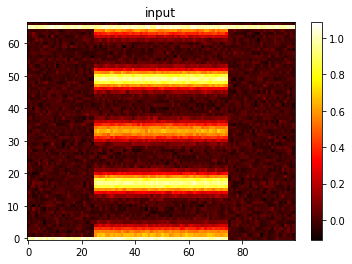

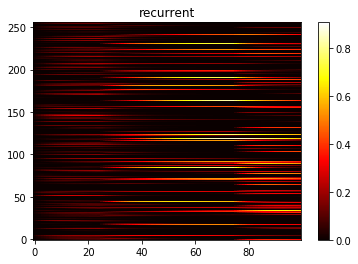

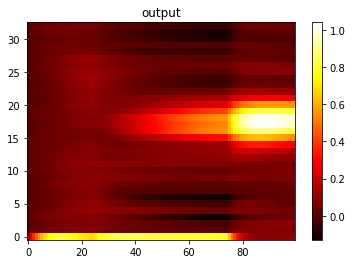

In [8]:
import standard_analysis
# model_dir = 'debug'
rule = 'contextdm1'
standard_analysis.easy_activity_plot(run_model, rule)